In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
import scipy as sp
from scipy import linalg
import scipy.linalg as la
import cairosvg
from PIL import Image

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

# Get Data

In [3]:
#pull these from hdf5
s_df_xz = pd.read_hdf('Data/FigS10.hdf5', 's_df_xz')

# Prepare for clustering

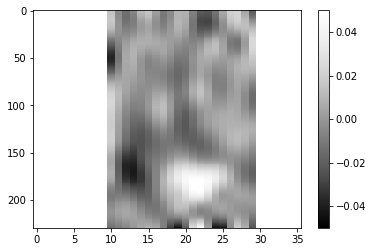

In [4]:
#an example filter
index = 1010 #using 150, 800, 5, 100, 400, 600 also look fine
plt.imshow(s_df_xz[s_df_xz['field']==4]['shifted_filters_corr'].loc[index], aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05) #examples: 5, 150, 100, 400, 600, 800

plt.colorbar()


plt.show()

In [5]:
#flattening
splines = np.asarray(s_df_xz['shifted_filters_corr'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 150*10))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[40:-40,13:23]
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [6]:
# #plot flattened array
# fig = plt.figure(figsize=(60,20))
# plt.imshow(spline_array)

In [7]:
# #now cropped array for clustering
# fig = plt.figure(figsize=(4,4))
# plt.imshow(spline_array_cropped, aspect='auto', cmap='Greys_r')

# # Figpath = 'Fig_temp/'
# # savename = Figpath+"Cropped_Flattened_splines_chat.pdf"
# # plt.savefig(savename, transparent=True, bbox_inches='tight')

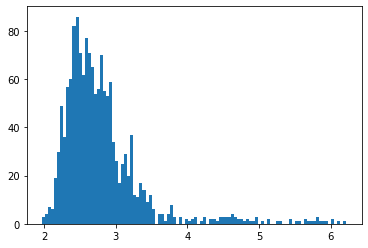

In [8]:
#check for low quality rois
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

plt.hist(np.amax(np.abs(zscored_spline_array), axis=0), bins=100)
plt.show()

In [9]:
#remove low quality rois
threshold = 2.2
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

s_df_xz_masked = s_df_xz.iloc[quality_mask].copy()

s_df_xz_masked.shape

(2725, 5)

# Mixture of Gaussian Model

In [10]:
#pull clustered data from hdf5
s_df_xz_masked = pd.read_hdf('Data/FigS10.hdf5', 's_df_xz_masked')

# Evaluating clustering and measuring cluster parameters

In [11]:
#make averages
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

average_filters = np.zeros((s_df_xz_masked['shifted_filters_corr'].iloc[0].shape[0], s_df_xz_masked['shifted_filters_corr'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = s_df_xz_masked[s_df_xz_masked['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters_corr']), axis=2)
    average_filters[:,:,i] = current_mean

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [12]:
#find ROI positions for plotting
s_df_xz_copy = s_df_xz_masked.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['x_position'].groupby(['new_cluster_assignment']).mean()

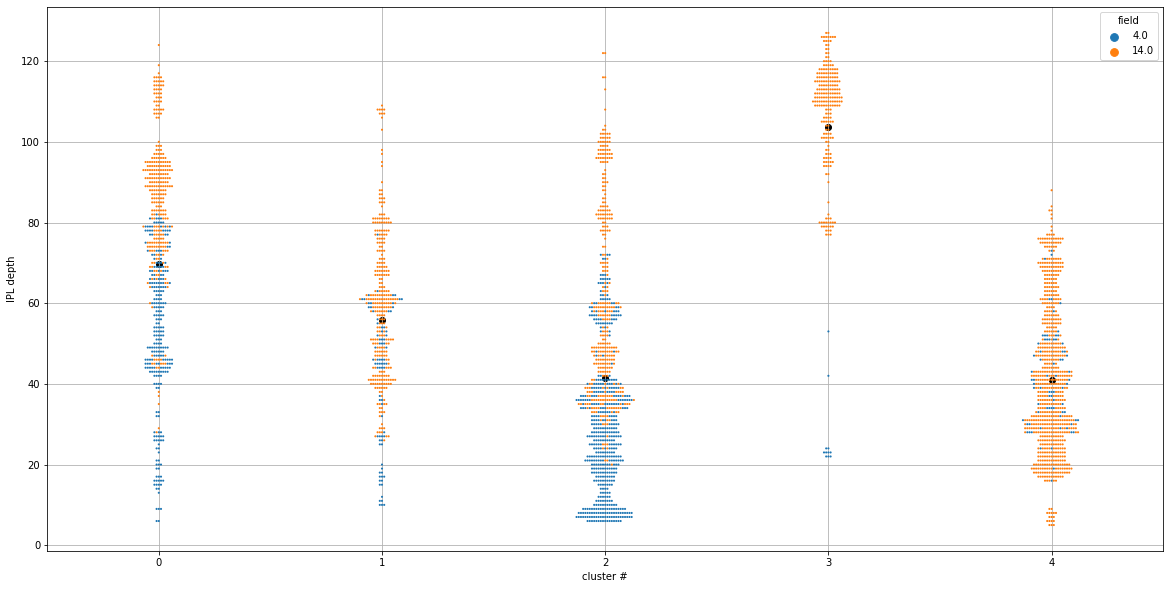

In [13]:
#plot ROI positions in field by cluster
n_bins = 10
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz['field']

fig=plt.figure(figsize=(20,10))


ax = sns.swarmplot(data=s_df_xz_masked, x="new_cluster_assignment", y="x_position", hue="field", alpha=1, cmap=cm, size=2.1,)
# plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)
# plt.colorbar()
plt.scatter(cluster_avg_depth.index, cluster_avg_depth, color='k')

axes = plt.gca()
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_ipl_depth_chat.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

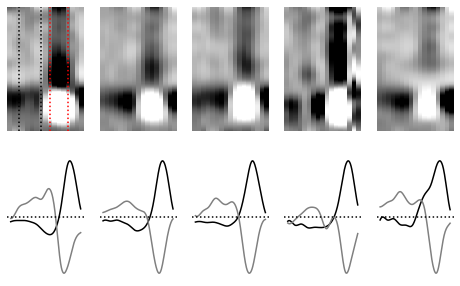

In [14]:
#plot cluster average RFs and normalized temporal kernels
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, 1, 1, 1, 1,1,1,1,]
latency = np.zeros(len(polarity))
surround_strength = np.zeros(len(polarity))

fig, ax = plt.subplots(2, 5, figsize=(8, 5))

for i, clust in enumerate(clusters):

#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12)
    ax[0, i].imshow(average_filters[:,10:27,i]/np.linalg.norm(average_filters[50:-50,11:19,i]), aspect='auto', cmap='Greys_r', vmin=-0.08, vmax=0.08)
    ax[0, i].axis('off')
#     ax[0, i].colorbar()

    if i == 0:
        ax[0, i].axvline(12-10, color='k', linestyle='dotted')
        ax[0, i].axvline(17-10, color='k', linestyle='dotted')
        ax[0, i].axvline(19-10, color='r', linestyle='dotted')
        ax[0, i].axvline(23-10, color='r', linestyle='dotted')
    
    avg_filter_flipped = average_filters[:,:,i]*polarity[i] #deal with off cells
    center = np.mean(avg_filter_flipped[:,19:24], axis=1)/np.amax(np.mean(avg_filter_flipped[100:240,19:24], axis=1))
    surround = np.mean(avg_filter_flipped[:,12:18], axis=1)/np.amin(np.mean(avg_filter_flipped[100:240,12:18], axis=1))
    ax[1, i].plot(np.mean(avg_filter_flipped[15:-15,19:24], axis=1)/np.amax(np.mean(avg_filter_flipped[100:240,19:24], axis=1)), color='k')
    ax[1, i].plot(np.mean(avg_filter_flipped[15:-15,12:18], axis=1)/np.amin(np.mean(avg_filter_flipped[100:200,12:18], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[1, i].axhline(color='k', linestyle='dotted')
    ax[1, i].set_yticklabels([])
    ax[1, i].set_xticklabels([])
    ax[1, i].axis('off')
    
    latency[i] = np.argmax(center)-np.argmax(surround)
    surround_strength[i] = np.amin(np.mean(avg_filter_flipped[100:240,12:18], axis=1))/np.amax(np.mean(avg_filter_flipped[100:240,19:24], axis=1))

# plt.colorbar()
# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_chat_scale_flipped.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

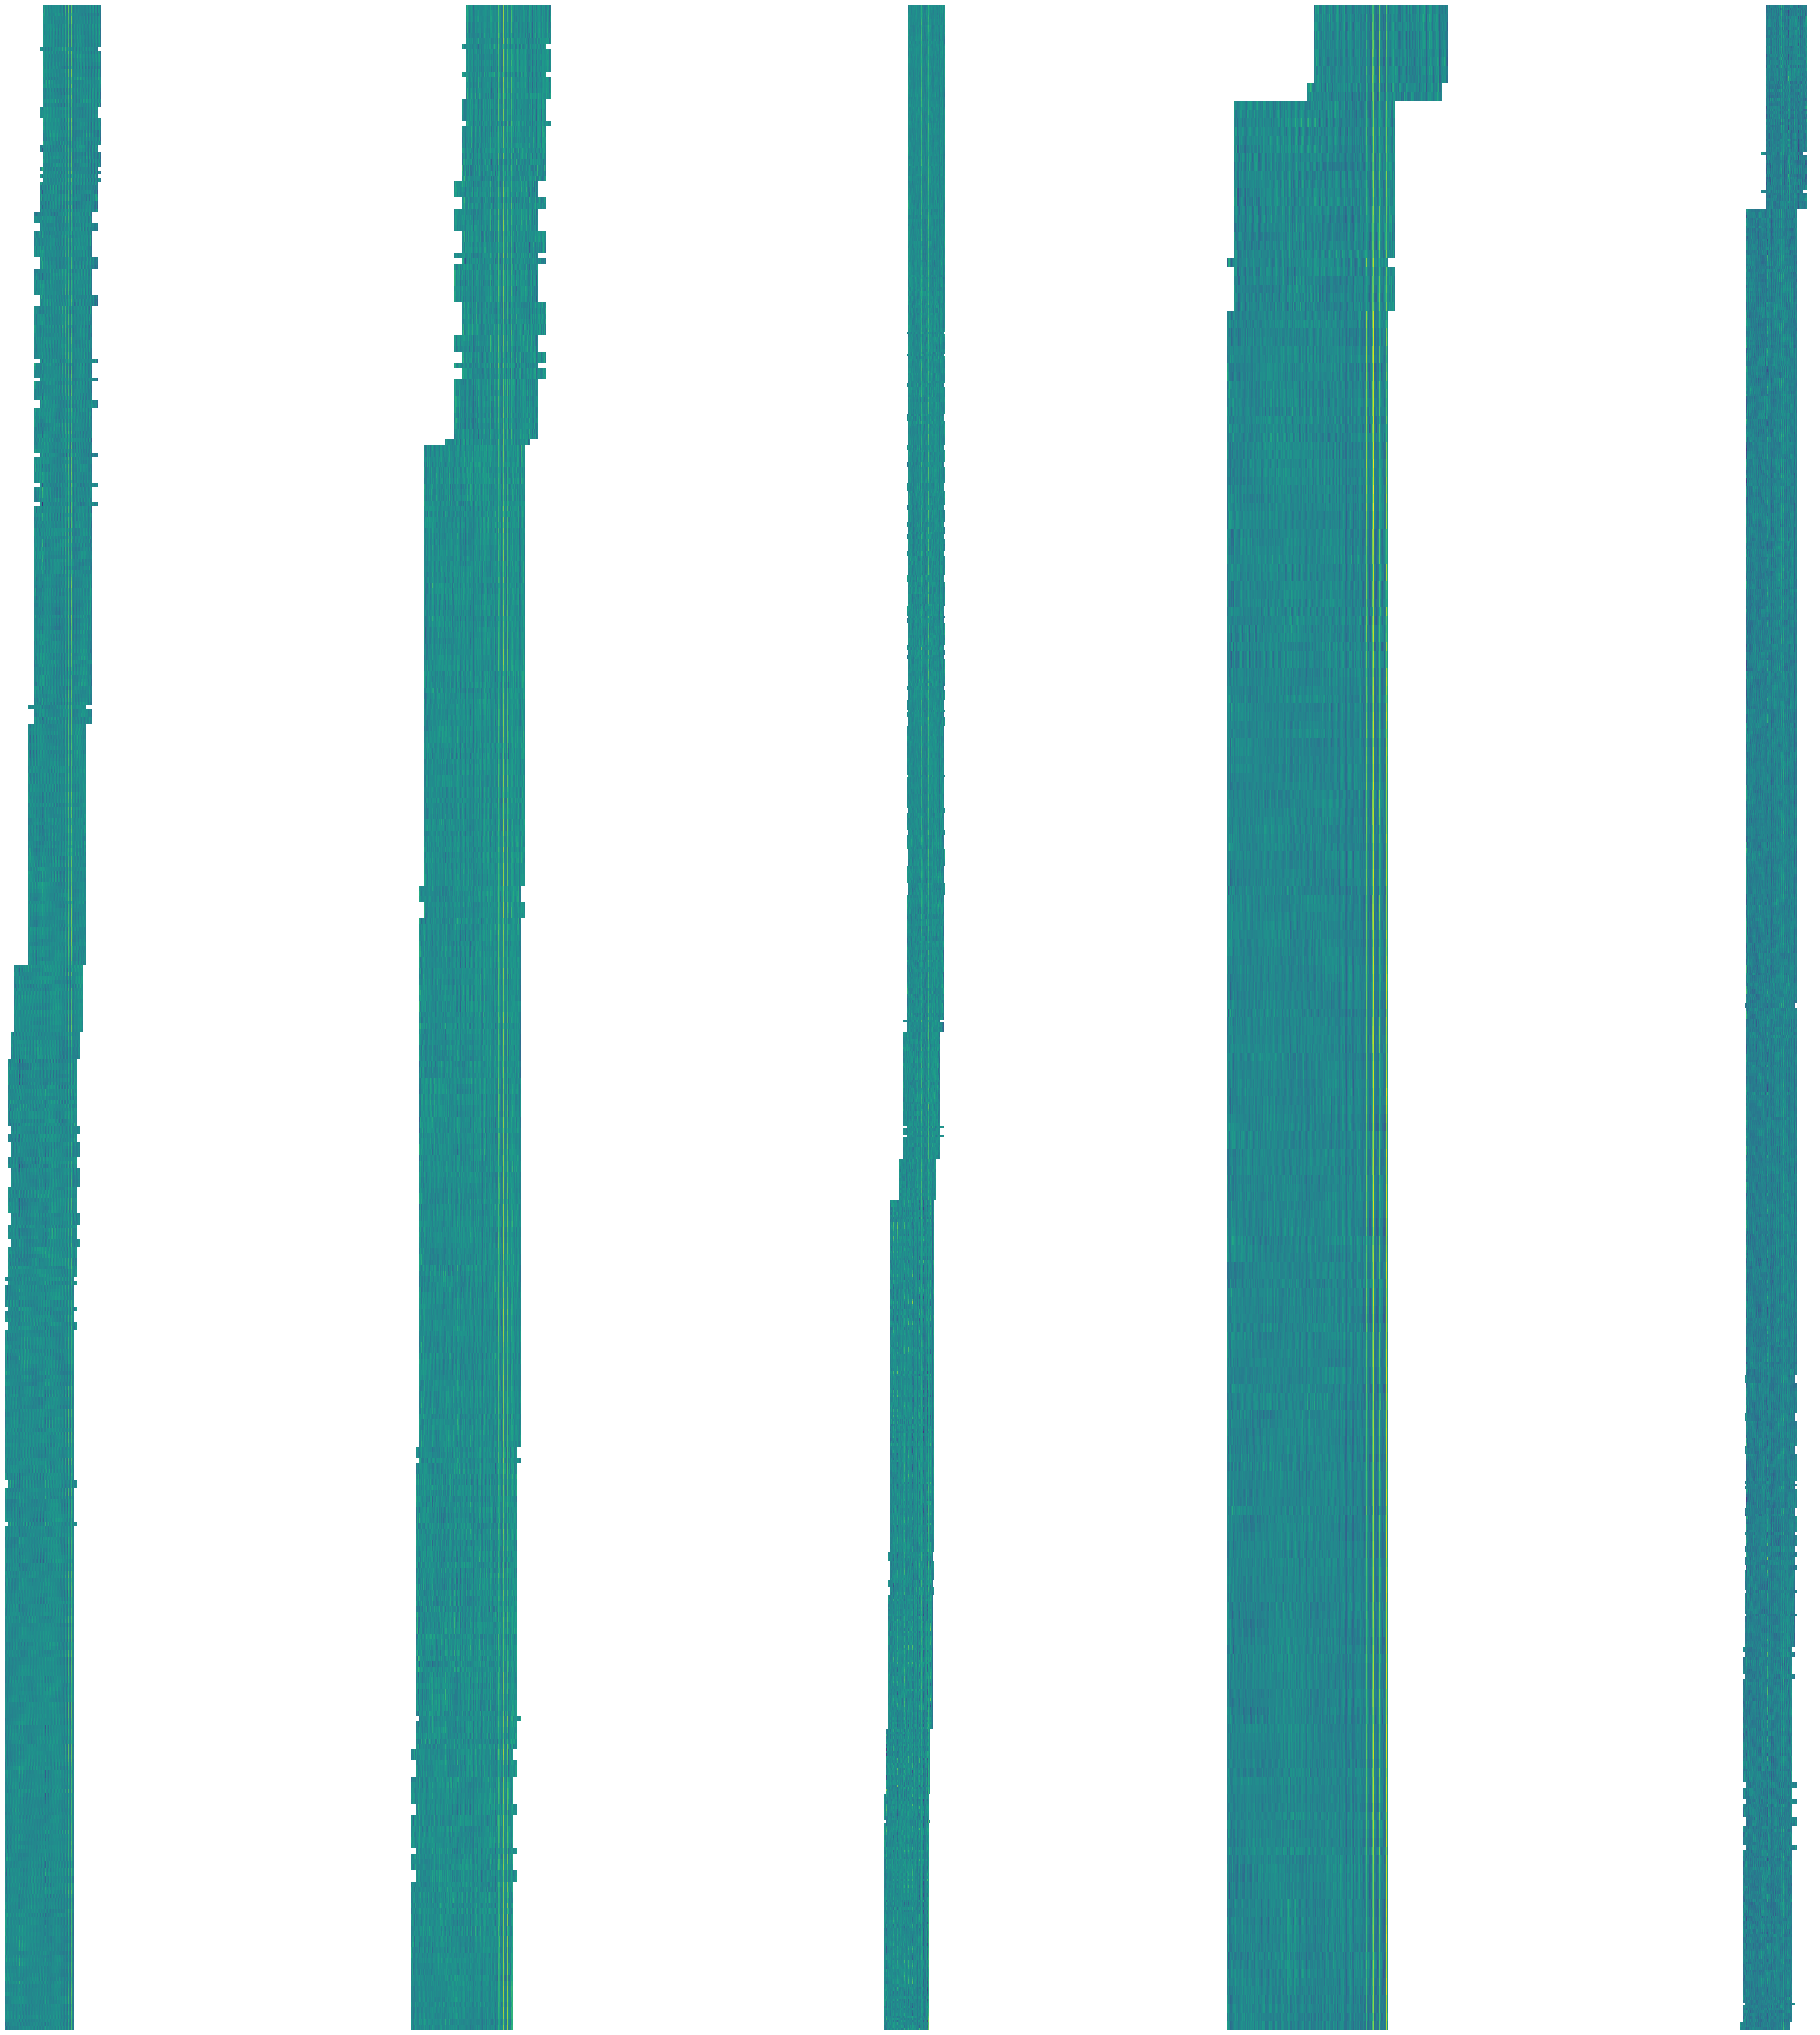

In [15]:
# by-cluster flattened responses
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))
polarity = [1, 1, 1, 1, 1,]

fig, ax = plt.subplots(1, 5, figsize=(50, 50))
for i in range(5):
    
    ax[i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==i], cmap='viridis', aspect=300,) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

In [16]:
# response in center vs. surround for each individual ROI

center_single_rois = np.nanmean(np.dstack(s_df_xz_masked['shifted_filters_corr'])[:,19:24,:], axis=1)
surround_single_rois = np.nanmean(np.dstack(s_df_xz_masked['shifted_filters_corr'])[:,12:18,:], axis=1)

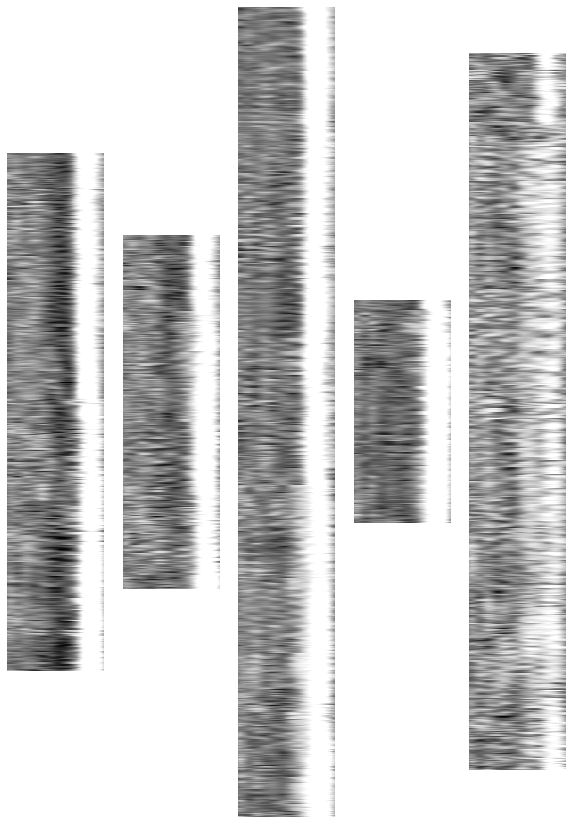

In [17]:
#center responses by roi/cluster
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

range_vals = 0.03

fig, ax = plt.subplots(1, 5, figsize=(10, 20))
for i in range(5):
   
    ax[i].imshow(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=2, vmin=-range_vals, vmax=range_vals) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    
#     ax[1, i].imshow(surround_single_rois[:, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=3, vmin=-range_vals, vmax=range_vals) 
#     ax[1, i].set_yticklabels([])
#     ax[1, i].set_xticklabels([])
#     ax[1, i].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_individual_roi_centers.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

(538, 200)
(368, 200)
(842, 200)
(232, 200)
(745, 200)


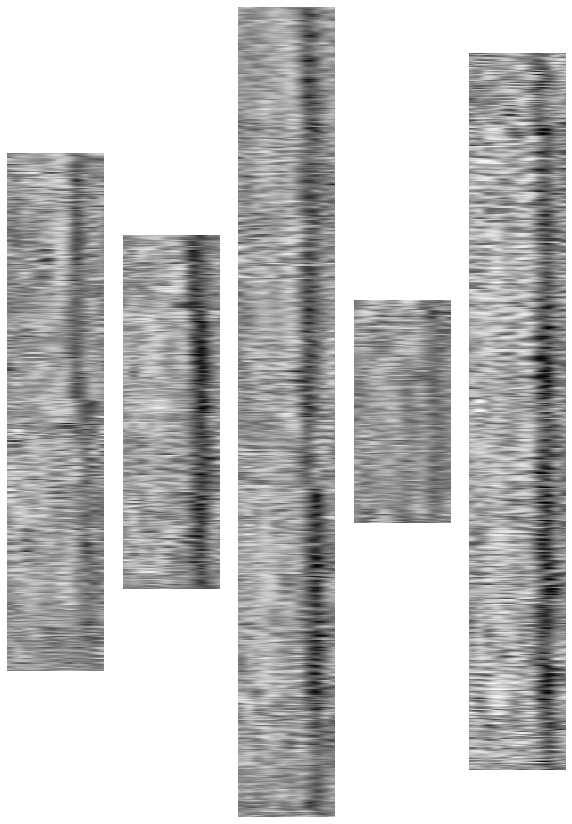

In [18]:
#surround responses by roi/cluster
clusters = np.unique(np.array(s_df_xz_masked['new_cluster_assignment']))

range_vals = 0.03

fig, ax = plt.subplots(1, 5, figsize=(10, 20))
for i in range(5):
   
    #     ax[i].imshow(center_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=2, vmin=-range_vals, vmax=range_vals) 
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')
    
    ax[i].imshow(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T, cmap='Greys_r', aspect=2, vmin=-range_vals, vmax=range_vals) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    print(surround_single_rois[15:-15, s_df_xz_masked['new_cluster_assignment']==i].T.shape)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_individual_roi_surrounds.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

# Cluster summary data

In [19]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/FigS10.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']

In [20]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

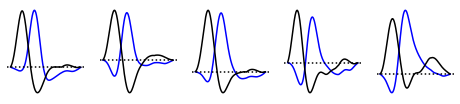

In [21]:
#plot model responses for 1000 um/s


# convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



dsi = np.zeros(average_filters.shape[2])
#get convolved responses
fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
for i in range(average_filters.shape[2]):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,10:32,i]
    edge_buffer = 15 
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'
    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
#     peak_y = index_max[1]
#     print(peak_y)
    peak_y = 11

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(np.abs(response))
    max_response_rev = np.amax(np.abs(response_rev))
    dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)
#     print(dsi)

    ax[i].plot(response, color='b')
    ax[i].plot(response_rev, color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

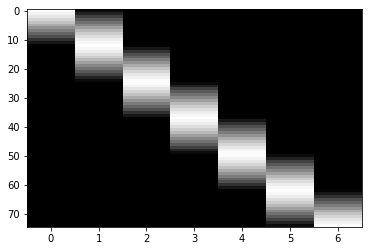

In [22]:
#plot of stimulus image
plt.imshow(stimulus_image, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_inward_right.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

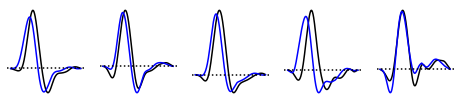

In [23]:
# convolution across full kernel


convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 240
convolution_params['distance_covered'] = 240
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



dsi = np.zeros(average_filters.shape[2])
#get convolved responses
fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
for i in range(average_filters.shape[2]):
    # get the necessaries
    spline = average_filters[:,10:32,i]
    edge_buffer = 15 #
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'centered'#
    
    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
#     peak_y = index_max[1]
    peak_y = 11

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2+1)]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(np.abs(response))
    max_response_rev = np.amax(np.abs(response_rev))
    dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)
#     print(dsi)

    ax[i].plot(response, color='k')
    ax[i].plot(response_rev, color='b')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_chat_1000_centered.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

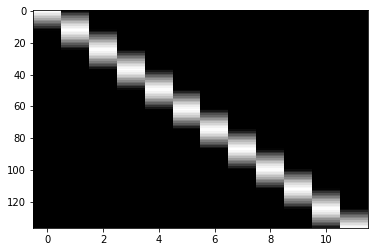

In [24]:
#stimulus image
plt.imshow(stimulus_image, cmap='Greys_r', aspect='auto')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_inward_full.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [25]:
def convolved_dsis_left(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

    cluster_list = [0, 1, 2, 3, 4]
    dsi = np.zeros(5)
    dsi_off = np.zeros(5)

    if velocity == 1000:
        fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
    
#     fig, ax = plt.subplots(1, 5, figsize=(20, 1.6666))
    for i in cluster_list:
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,10:32,i]
        edge_buffer = 15 
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'
        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 10

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)] #changing this to try to center better
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)

        dsi_all = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)
        
        if velocity == 1000:
            
            ax[i].imshow(spline_cut, aspect='auto', cmap='Greys_r')
            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])
            ax[i].axis('off')

    return dsi, dsi_off

In [26]:
def convolved_dsis_centered(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution


    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 260
    convolution_params['distance_covered'] = 260

    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

    cluster_list = [0, 1, 2, 3, 4]
    dsi = np.zeros(5)
    dsi_off = np.zeros(5)

    if velocity == 1000:
        fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
    
#     fig, ax = plt.subplots(1, 5, figsize=(20, 1.6666))
    for i in cluster_list:
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,10:32,i]
        edge_buffer = 15 #
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'centered'#
        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 11

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y):np.int(peak_y + kernel_length)] #changing this to try to center better
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2+1)]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[i] = (max_response - max_response_rev) / (max_response + max_response_rev)

        dsi_all = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)
        
        if velocity == 1000:
            
            ax[i].imshow(spline_cut, aspect='auto', cmap='Greys_r')
            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])
            ax[i].axis('off')


    return dsi, dsi_off

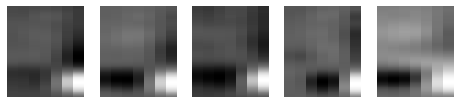

In [27]:
#run models of half RF
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_left = np.zeros((len(velocities), 5))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_left(velocity, convolution_params)
    dsi_all_all_left[i, :] = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)

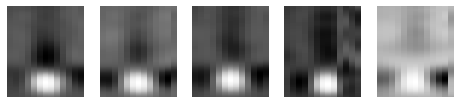

In [28]:
#run models of full RF
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered = np.zeros((len(velocities), 5))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered(velocity, convolution_params)
    dsi_all_all_centered[i, :] = dsi#np.where(cluster_avg_depth<0.5, dsi, dsi_off)

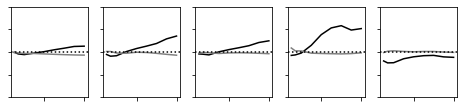

In [29]:
#plot tuning curves
fig, ax = plt.subplots(1, 5, figsize=(8, 1.6666))
for i in range(5):

#     ax[i].plot(velocities, dsi_all_all[:, i]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_left[:, i]*-1, color='k')
#     ax[i].plot(velocities, dsi_all_all_full[:, i], color='grey')
    ax[i].plot(velocities, dsi_all_all_centered[:, i]*-1, color='grey')
    ax[i].set_ylim([-1, 1])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])


plt.show()

In [30]:
# comparison with ubiquitous iglusnfr clustering

ubiquitous_cluster_dsis = np.load('Data/dsi_all_all_ubiquitous.npy')
ipl_depth_order = [0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4]

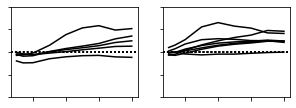

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(5, 1.6666))
# colors3 = cm.get_cmap('winter')
for i in range(5):

#     ax[i].plot(velocities, dsi_all_all[:, i]*-1, color='k')
    ax[0].plot(velocities, dsi_all_all_left[:, i]*-1, label=str(i), color='k') #color=colors3(np.amax(dsi_all_all_right[:, i])*5))

    ax[0].set_ylim([-1, 1])
    ax[0].axhline(color='k', linestyle='dotted')
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
#     ax[0].legend()

for i in ipl_depth_order[:7]:
    ax[1].plot(velocities, ubiquitous_cluster_dsis[:, i]*-1, color='k')#color=colors3(np.amax(ubiquitous_cluster_dsis[:, i]*-1)*5)) #

    ax[1].set_ylim([-1, 1])
    ax[1].axhline(color='k', linestyle='dotted')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
